# Large Scale Kernel Method

Authors: MADALI Nabil,Virgile Rennard,Mélanie Karlsen


## Table of Contents

0. [Introduction](#Introduction)
1. [Kernel Methods ](#Kernel-Methods)
2. [Random Fourier Features ](#Random-Fourier-Features) 
3. [Nyström Approximation ](#Nyström-Approximation)
4. [Performance Overview ](#Performance-Overview)



#Introduction
In order to avoid calculating the kernel matrix, one common approach is to approximate a kernel learning problem with a linear prediction problem.  It is often achieved by generating a vector representation of data that approximates the kernel similarity between any two data points.  The best known approaches in this category are the  random Fourier features  and the Nystrom method . The random Fourier function and the Nystrom method have been successfully applied to effective kernel learning.  In this work, we examine the fundamental differences between these two approaches and how they affect generalization performance

#Kernel-Methods

## SVM Classifier

We’ll consider a binary classification framework. Suppose we have training observations $X_1,....,X_n \in \mathbb{R}^p$ , and training labels $y_1,....,y_n \in \{ -1, 1 \}$

We can define the non-linearly separable SVM framework as follows :
\begin{equation}
min_{w \in \mathbb{R}^p,b \in \mathbb{R},\epsilon \in \mathbb{R}^n } \frac{1}{2} \mid \mid w  \mid \mid_{2}^{2} +\sum_{i} \epsilon_i
\end{equation}

subject to :

\begin{equation}
\begin{split}
y_i (W^T X +b ) & \geq 1 - \epsilon_i ,i=1,...,n \\
 &  \epsilon_i \geq 0 ,i=1,...,n
\end{split}
\end{equation}
We can rewrite this as a dual problem using a Lagrange formulation :
\begin{equation}
max_{\alpha \in \mathbb{R}^n }  \sum_i \alpha_i - \frac{1}{2} \alpha_i \alpha_j  y_i y_j  X_i^T X_j
\end{equation}

subject to :
\begin{equation}
\begin{split}
 0 & \leq  \alpha_i  \leq C ,i=1,...,n \\
 &  \epsilon_i  ,i=1,...,n
\end{split}
\end{equation}
The binary classifier is : $f(x)=sign(\sum_i  \alpha_i   y_i   X_i^T X_i)$

## The kernel trick

A symmetric function $K :  \mathcal{X} \times \mathcal{X} \rightarrow \mathbb{R} $  is a kernel if there exists a mapping function $\phi : \mathcal{X} \rightarrow \mathbb{R}$ from the instance space $\mathcal{X}$ to a Hilbert space H such that K can be written as an inner product in H :


\begin{equation}
K(X,{X}')=<\phi(X),\phi({X}')>
\end{equation}

The Kernel trick can be visualized as a projection of an initial problem with a complex decision frontier into feature space in which the decision frontier is way easier and faster to build.

![alt text](https://maelfabien.github.io/assets/images/kernel_trick.jpg)

The Kernel SVM can be expressed as :

\begin{equation}
max_{\alpha \in \mathbb{R}^n }  \sum_i \alpha_i - \frac{1}{2} \alpha_i \alpha_j  y_i y_j  K(X_i^T, X_j)
\end{equation}

subject to :
\begin{equation}
\begin{split}
 0 & \leq  \alpha_i  \leq C ,i=1,...,n \\
 &  \sum_i \alpha_i y_i=0  ,i=1,...,n
\end{split}
\end{equation}
The binary classifier is : $f(x)=sign(\sum_i  \alpha_i   y_i   K(X_i^T ,X_i))$

### I.Import

In [0]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
from time import time
from math import pi
plt.style.use('ggplot')

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_svmlight_file
from sklearn.datasets import make_classification
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.svm import SVC, LinearSVC

from scipy.sparse.linalg import svds
from scipy.linalg import svd
from scipy.sparse import csc_matrix
from numpy.linalg import multi_dot
from numpy.linalg import norm

### II. Generate data

In [0]:
X, y = make_classification(n_samples=100000)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

n1, p = X_train.shape
n2 = X_test.shape[0]

print("Training samples :", n1)
print("Test samples:", n2)
print("Features:", p)

Training samples : 75000
Test samples: 25000
Features: 20


### III. Linear SVC

In [4]:
# Train
t0 = time()
clf_lin = LinearSVC(dual=False)
clf_lin.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))

done in 0.119s


In [5]:
# Test
t1 = time()
timing_linear = time() - t1
y_pred = clf_lin.predict(X_test)
print("done in %0.3fs" % (time() - t1))

done in 0.002s


In [6]:
# Accuracy
accuracy_linear = accuracy_score(y_pred, y_test)
print("classification accuracy: %0.3f" % accuracy_linear)

classification accuracy: 0.888


# Random-Fourier-Features

To accelerate the training of kernel machines,  Random Fourier Feature propose to map the input data to a randomized low-dimensional feature space and then apply existing fast linear methods. The randomized features are designed so that the inner products of the transformed data are approximately equal to those in the feature space of a user specified shift-invariant kernel.


The first set of random features consists of random Fourier bases $cos(w^{'}x+b)$ where $w \in \mathbb{R}^d  $ and $b \in \mathbb{R}$ are random variables. These mappings project data points on a randomly chosen line,and then pass the resulting scalar through a sinusoidal function .Drawing the direction of these lines from an appropriate distribution guarantees that the product of two transformed points will approximate a desired shift-invariant kernel.The following classical theorem from harmonic analysis provides the key insight behind this trans-formation:

##Bochner 
A continuous kernel k(x,y) =k(x−y) on $\mathbb{R}^d $ is positive definite if and only if $k(\delta )$ is the Fourier transform of a non-negative measure.

If a shift-invariant kernel $k(\delta )$ is properly scaled, Bochner’s theorem guarantees that its Fourier transform $p(w)$ is a proper probability distribution. Defining $\zeta_w(x) =e^{j w^{'} x }$, we have
 \begin{equation*}
        k(x-y) = \int_{\mathbb{R}^d }p(w) e^{j w^{'} (x-y)  }\partial w E_w [\zeta_w(x) \zeta_w(x)^{*}]
    \end{equation*}
so $\zeta_w(x) \zeta_w(x)^{*}$ is an unbiased estimate of k(x,y) when w is drawn from p.

Since both the probability distribution p(ω)and the kernel k(∆) are real, the integral converges when the complex exponentials are replaced with cosines. Therefore, we may obtain a real-valued mapping that satisfies the condition  $E [Z_w(x) Z_w(x)^{*}]= k(x,y)$ by setting $Z_w(x) =\sqrt{2}cos(w^{'}x+b)$ where w is drawn from p(w) and b is drawn uniformly from $[0,2\pi]$ That $Z_w(x)Z_w(y)$ has expected value k(x,y) is a consequence of the sum of angles formula.

We can lower the variance of the estimate of the kernel by concatenating D randomly chosen $Z_w$ into one D-dimensional vector z and normalizing each component by $\sqrt{D}$ The inner product $z(x)^{'}z(y) = \frac{1}{D}  \sum_{j=1}^D Z_{w_j}(x)Z_{w_j}(y) $ is a sample average of $Z_w$ and is there fore a lower variance approximation to the expectation.


Since  $Z_w$  is bounded between $+ \sqrt{2}$ and $- \sqrt{2}$ or a fixed pair of points x and y, Hoeffd-ing’s inequality guarantees exponentially fast convergence in D between $z(x)^{'}z(y)$ and $k(x,y)$ :

\begin{equation*}
        \mathbb{P} ( \mid z(x)^{'}z(y)- k(x,y) \mid  \geq \epsilon  ) \leq  2exp(-D \epsilon^2 /d)
    \end{equation*}
 

## Pseudo-Code
1. Set the number of random kernel features to c

2. Draw $w_1,...,w_c \sim P(W)$ and $b_1,...,b_c \sim [0,2\pi]$

3. Map training points $x_1,....,x_n  \in  \mathbb{R}^p$  to their random kernel features $\hat{\phi}(X_1),...,\hat{\phi}(X_n) \in \mathbb{R}^c  $ where $\hat{\phi}(X_i)=\sqrt{\frac{2}{c}}cos(W_i^TX+b_j),j \in [1,...,c] $ . c is present in the fraction to create a mean.
4. Train a linear model (such as Linear SVM) on transformed data $\hat{\phi}(X_1),...,\hat{\phi}(X_n) \in \mathbb{R}^c $

In other words, to speed up the whole training process and get results that tend to be similar to RBF kernel, we pre-process the data and apply a linear SVM on top. It can be shown that this approximation will converge to the RBF Kernel.

In [0]:
def rank_trunc(gram_mat, k):
    
    u, s, vt = svds(gram_mat, k=k)
    gram_mat_k = np.dot(u, np.dot(np.diag(s), vt))

    return gram_mat_k

In [0]:
def random_features(X_train, X_test, gamma, c=300, seed=42):

    rng = np.random.RandomState(seed)
    n_samples, n_features = X_train.shape
    
    W = np.random.normal(0, np.sqrt(2*gamma), (n_features, c))
    b = np.random.uniform(0, 2*pi, (1,c))

    X_new_train = np.sqrt(2/n_features) * np.cos(np.dot(X_train, W) + b)
    X_new_test = np.sqrt(2/n_features) * np.cos(np.dot(X_test, W) + b)

    return X_new_train, X_new_test

In [0]:
n_samples, n_features = X_train.shape
gamma = 1. / n_features

In [0]:
Z_train, Z_test = random_features(X_train, X_test, gamma, c=800)

In [11]:
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

done in 21.688s


In [12]:
t1 = time()
accuracy = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t1))
print("classification accuracy: %0.3f" % accuracy)

done in 0.032s
classification accuracy: 0.912


# Nyström Approximation

The Nyström method is an efficient technique for  obtaining  a  low-rank  approximation  of a large  kernel  matrix  based  on  a  subset  of its  columns.    The  quality  of  the  Nyström approximation  highly  depends  on  the  sub-set  of  columns  used,  which  are  usually  selected  using  random  sampling .

The  Nyström  method  starts  by  selecting  a  subset  of $l << n$ columns  of K usually  by random  sampling.These columns represent the similarities between the subset of l data instances and all data instances.  Let $S$ be the set of the indices of selected columns, and  $\mathcal{R}$ be the set of the indices of remaining columns.  Without loss of generality, the columns and rows of K can be arranged as follows:

\begin{equation}
  K=
  \begin{bmatrix}
A & B \\ 
 B^T& C
\end{bmatrix}
\end{equation}

where A,B and C are  sub-matrices  of K whose  elements  are $ \{ K_{i,j} : i,j \in S \}$
 ,$\{ K_{i,j} : i \in S ,j \in S \mathcal{R} \}$ and  $\{ K_{i,j} : i,j \in \mathcal{R} \}$ respectively, and $K_{i,j}$ denotes the element of K at row i and column j.
 The Nyström method calculates a rank-l approxima-tion of K as (Williams and Seeger, 2001):
 
\begin{equation}
 \hat{K}_S= D A^{-1} D^T
\end{equation}

where D =$[A,B]^T$ is an $n \times l $ matrix which consists of the selected columns of K.

The  computational  complexity  of  calculating $A^{-1}$ is $\mathcal{O}(l^3)$ ,and  those  of  calculating rank-k Nyström approximation is $\mathcal{O}(l^3 +nlk +n^2k)$.

It should  be  noted  that  the  approximate  singular  vectors,  as  well  as  the  basis  of  the k-dimensional  space are, however, non-orthonormal  (Kumar et al., 2009c).

In  some  applications,  additional  steps  might  be  re-quired to obtain orthonormal vectors.  This, however,increases the computational complexity .

## Pseudo-code
1. Sample a set I of c indices uniformly in 1,...,n

2. Compute c $ \in \mathbb{R}^{n×c} $ with 
\begin{equation}
 c_{ij}=K(X_i,X_j),i \in 1,...,n , J \in I
\end{equation}

3. Form a matrix W $ \in \mathbb{R}^{c×c} $ with $W_{ij}=K(X_i,X_j),i,j \in I $

4. Compute $W_k \in \mathbb{R}^{c×c}$ the best rank-k approximation of W

5. Compute the final rank-k matrix of G :
\begin{equation}
 \hat{G}=CW_k^{-1}C^T \in \mathbb{R}^{n×n} 
\end{equation}

The complexity is \mathcal{O}(c^3+nck) . The convergence of this approximation has also been demonstrated.

In [0]:
def nystrom(X_train, X_test, gamma, c=500, k=200, seed=44):

    rng = np.random.RandomState(seed)
    n_samples = X_train.shape[0]
    idx = rng.choice(n_samples, c)

    X_train_idx = X_train[idx, :]

    W = rbf_kernel(X_train_idx, X_train_idx, gamma=gamma)
    
    u, s, vt = linalg.svd(W, full_matrices=False)
    
    u = u[:,:k]
    s = s[:k]
    vt = vt[:k, :]
    
    M = np.dot(u, np.diag(1/np.sqrt(s)))
    
    C_train = rbf_kernel(X_train, X_train_idx, gamma=gamma)
    C_test = rbf_kernel(X_test, X_train_idx, gamma=gamma)
    
    X_new_train = np.dot(C_train, M)
    X_new_test = np.dot(C_test, M)
    
    return X_new_train, X_new_test

In [0]:
Z_train, Z_test = nystrom(X_train, X_test, gamma, c=500, k=300, seed=44)

In [16]:
t1 = time()
accuracy = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t1))
print("classification accuracy: %0.3f" % accuracy)

done in 0.022s
classification accuracy: 0.922


In [15]:
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

done in 6.144s


# Gaussian Kernel SVC

In [20]:
# Train
t0 = time()
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))

done in 148.701s


In [21]:
# Test
t1 = time()
y_pred = clf.predict(X_test)
timing_kernel = time() - t1
print("done in %0.3fs" % (time() - t1))

done in 18.598s


In [22]:
# Accuracy
accuracy_kernel = accuracy_score(y_pred, y_test)
print("classification accuracy: %0.3f" % accuracy_kernel)



classification accuracy: 0.925


# Performance Overview

In [17]:
ranks = np.arange(20, 600, 50)
n_ranks = len(ranks)

timing_rkf = np.zeros(n_ranks)
timing_nystrom = np.zeros(n_ranks)
timing_linear = np.zeros(n_ranks)
timing_rbf = np.zeros(n_ranks)

accuracy_nystrom = np.zeros(n_ranks)
accuracy_rkf = np.zeros(n_ranks)
accuracy_linear = np.zeros(n_ranks)
accuracy_rbf = np.zeros(n_ranks)

print("Training SVMs for various values of c...")

for i, c in enumerate(ranks):
    
    print(i, c)

    ## Nystorm
    Z_ny_train, Z_ny_test = nystrom(X_train, X_test, gamma, c=c, k=300, seed=44)

    t0 = time()
    clf = LinearSVC(dual=False)
    clf.fit(Z_ny_train, y_train)
    accuracy_nystrom[i] = clf.score(Z_ny_test, y_test)
    timing_nystrom[i] = time() - t0

    ## Random Kernel Feature
    Z_rkf_train, Z_rkf_test = random_features(X_train, X_test, gamma, c=c, seed=44)
    t0 = time()
    clf = LinearSVC(dual=False)
    clf.fit(Z_rkf_train, y_train)
    accuracy_rkf[i] = clf.score(Z_rkf_test, y_test)
    timing_rkf[i] = time() - t0

    ## Linear
    t0 = time()
    clf = LinearSVC(dual=False)
    clf.fit(X_train, y_train)
    accuracy_linear[i] = clf.score(X_test, y_test)
    timing_linear[i] = time() - t0
    
    ## RBF
    t0 = time()
    clf = SVC(kernel='rbf')
    clf.fit(X_train, y_train)
    accuracy_rbf[i] = clf.score(X_test, y_test)
    timing_rbf[i] = time() - t0

Training SVMs for various values of c...
0 20
1 70
2 120
3 170
4 220
5 270
6 320
7 370
8 420
9 470
10 520
11 570


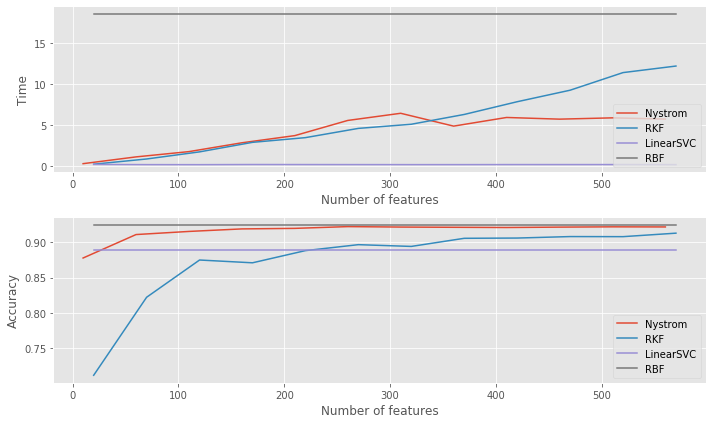

In [23]:
f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks-10, timing_nystrom, '-', label='Nystrom')
ax1.plot(ranks, timing_rkf, '-', label='RKF')
ax1.plot(ranks, timing_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax1.plot(ranks, timing_kernel * np.ones(n_ranks), '-', label='RBF')

ax1.set_xlabel('Number of features')
ax1.set_ylabel('Time')
ax1.legend(loc='lower right')

ax2.plot(ranks-10, accuracy_nystrom, '-', label='Nystrom')
ax2.plot(ranks, accuracy_rkf, '-', label='RKF')
ax2.plot(ranks, accuracy_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax2.plot(ranks, accuracy_kernel * np.ones(n_ranks), '-', label='RBF')
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')
plt.tight_layout()
plt.show()